<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/2_3_ExploreData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# =========================
# 0) Setup (Colab + PySpark)
# =========================
!pip -q install pyspark==3.5.1

from google.colab import drive
drive.mount('/content/drive')  # authorize to access your CSV on Drive

from pyspark.sql import SparkSession, functions as F, types as T
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Create Spark session
spark = SparkSession.builder.appName("ChicagoCrime2017").getOrCreate()

# === Path to your CSV on Google Drive ===
FILE_PATH = "/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv"

# Read CSV with header and schema inference
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(FILE_PATH))

# Column fallback (handles small naming variations across dataset versions)
COL_DATE = "Date" if "Date" in df.columns else "ReportedDate"
COL_CAT  = "Primary Type" if "Primary Type" in df.columns else ("PrimaryType" if "PrimaryType" in df.columns else "Primary_Type")
COL_LAT  = "Latitude" if "Latitude" in df.columns else "latitude"
COL_LON  = "Longitude" if "Longitude" in df.columns else "longitude"

# Parse timestamp (supporting 12h and 24h patterns commonly used by this dataset)
ts1 = F.to_timestamp(F.col(COL_DATE), "MM/dd/yyyy hh:mm:ss a")
ts2 = F.to_timestamp(F.col(COL_DATE), "MM/dd/yyyy HH:mm:ss")
df = df.withColumn("ts", F.coalesce(ts1, ts2))

# Cast boolean-like fields if present
for bcol in ["Arrest", "Domestic"]:
  if bcol in df.columns:
    df = df.withColumn(bcol, F.col(bcol).cast(T.BooleanType()))

# Derive time fields (Spark dayofweek: 1=Sunday, 7=Saturday)
df = (
  df.withColumn("Year",  F.year("ts"))
    .withColumn("Month", F.month("ts"))
    .withColumn("Hour",  F.hour("ts"))
    .withColumn("WeekdayNum", F.dayofweek("ts"))
    .withColumn(
        "Weekday",
        F.when(F.col("WeekdayNum")==2, "Monday")
         .when(F.col("WeekdayNum")==3, "Tuesday")
         .when(F.col("WeekdayNum")==4, "Wednesday")
         .when(F.col("WeekdayNum")==5, "Thursday")
         .when(F.col("WeekdayNum")==6, "Friday")
         .when(F.col("WeekdayNum")==7, "Saturday")
         .when(F.col("WeekdayNum")==1, "Sunday")
         .otherwise("Unknown")
    )
)

# Keep only 2017 to match the report scope
df2017 = df.filter(F.col("Year") == 2017)

# Output directory for all figures
os.makedirs("/content/figs", exist_ok=True)

# High-DPI for publication-quality figures
plt.rcParams.update({"figure.dpi": 150})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


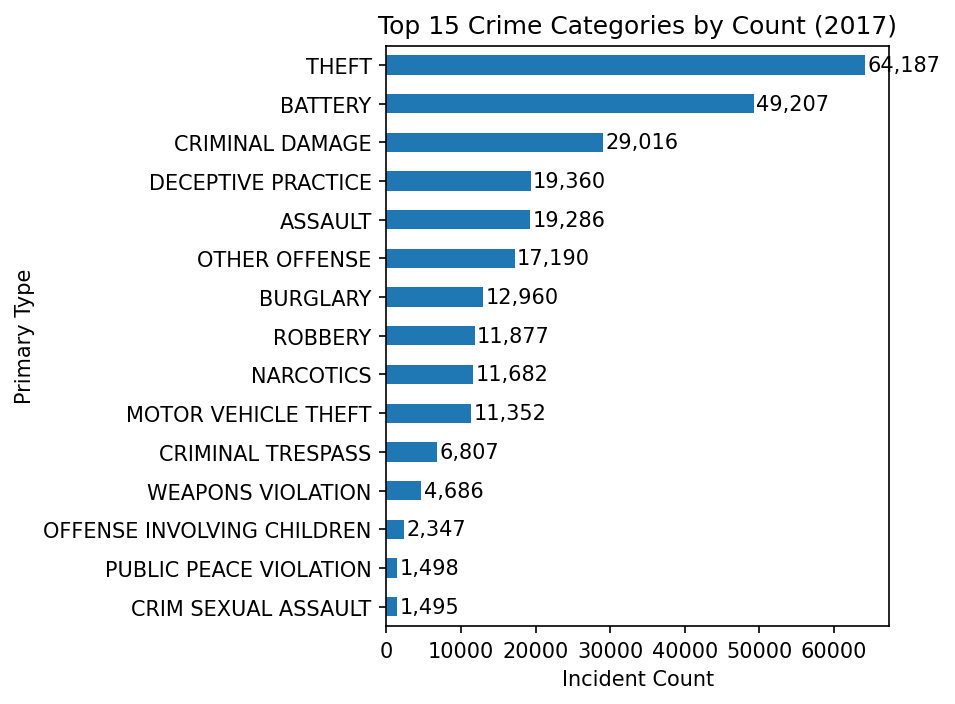

In [15]:
# ===========================================
# Figure 5: Top 15 Crime Categories by Count
# ===========================================
top_cat = (
    df2017.groupBy(F.col(COL_CAT)).count()
          .orderBy(F.desc("count"))
          .limit(15)
).toPandas()

# Sort ascending for a clean horizontal bar chart
top_cat = top_cat.sort_values("count", ascending=True)

ax = top_cat.plot(kind="barh", x=COL_CAT, y="count", legend=False)
ax.set_title("Top 15 Crime Categories by Count (2017)")
ax.set_xlabel("Incident Count")
ax.set_ylabel("Primary Type")

# Annotate counts at the end of bars
for p in ax.patches:
  w = int(p.get_width())
  ax.text(w + 300, p.get_y() + p.get_height() / 2, f"{w:,}", va="center")

plt.tight_layout()
plt.savefig("/content/figs/figure5_primary_type_by_count.png")
plt.show()

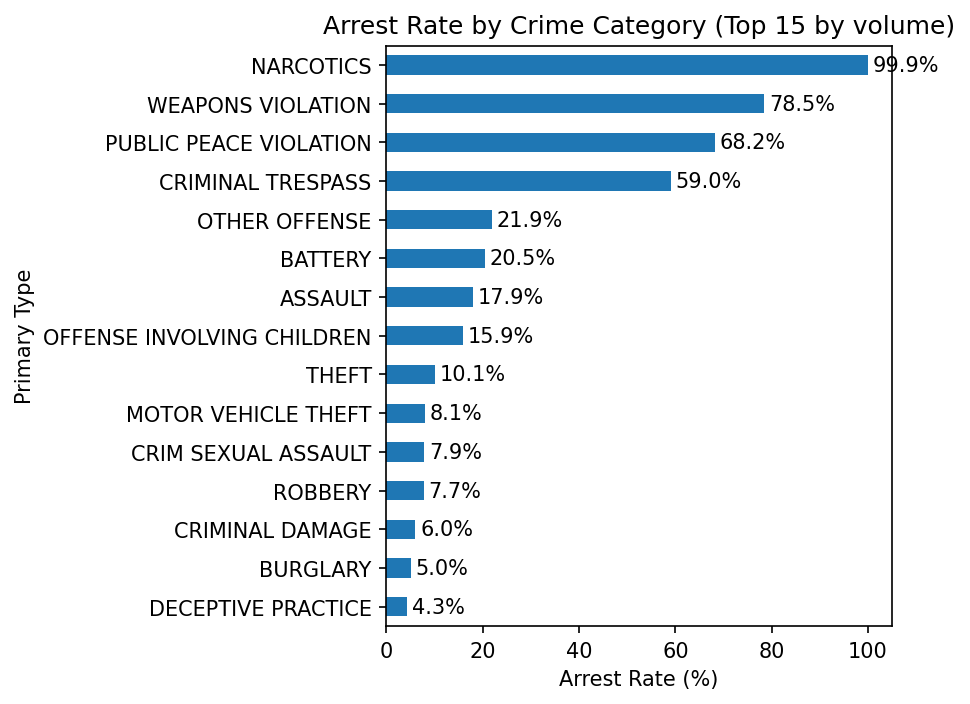

In [16]:
# ======================================================
# Figure 6: Arrest Rate by Crime Category (Top 15 by vol)
# ======================================================
if "Arrest" in df2017.columns:
  agg = (
      df2017.groupBy(F.col(COL_CAT))
            .agg(F.count("*").alias("n"),
                 F.sum(F.when(F.col("Arrest") == True, 1).otherwise(0)).alias("arrests"))
  ).withColumn("arrest_rate", (F.col("arrests") / F.col("n")) * 100)

  top15 = agg.orderBy(F.desc("n")).limit(15).toPandas()
  top15 = top15.sort_values("arrest_rate", ascending=True)

  ax = top15.plot(kind="barh", x=COL_CAT, y="arrest_rate", legend=False)
  ax.set_title("Arrest Rate by Crime Category (Top 15 by volume)")
  ax.set_xlabel("Arrest Rate (%)")
  ax.set_ylabel("Primary Type")

  # Annotate percentages
  for p, v in zip(ax.patches, top15["arrest_rate"].tolist()):
    ax.text(p.get_width() + 1, p.get_y() + p.get_height()/2, f"{v:.1f}%", va="center")

  plt.tight_layout()
  plt.savefig("/content/figs/figure6_arrest_rate_by_category.png")
  plt.show()
else:
  print("Column 'Arrest' not found; skipping Figure 6.")



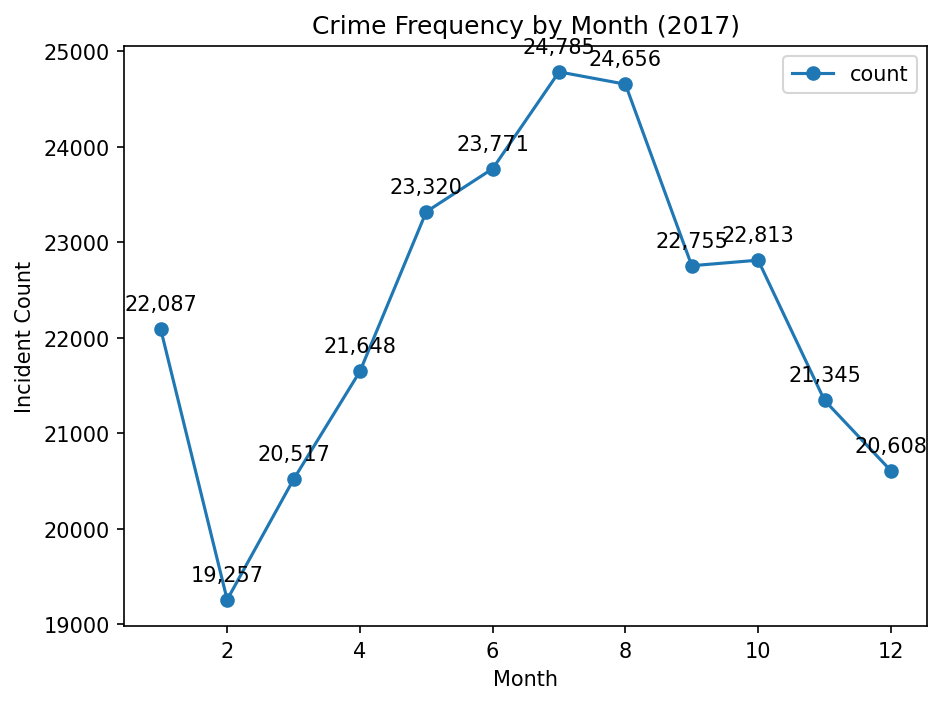

In [17]:
# ==========================================
# Figure 7: Crime Frequency by Month (2017)
# ==========================================
month_cnt = (
    df2017.groupBy("Month").count()
          .orderBy("Month")
).toPandas()

ax = month_cnt.plot(kind="line", x="Month", y="count", marker="o")
ax.set_title("Crime Frequency by Month (2017)")
ax.set_xlabel("Month")
ax.set_ylabel("Incident Count")

# Annotate counts
for x, y in zip(month_cnt["Month"], month_cnt["count"]):
  ax.text(x, y + 200, f"{int(y):,}", ha="center")

plt.tight_layout()
plt.savefig("/content/figs/figure7_by_month.png")
plt.show()


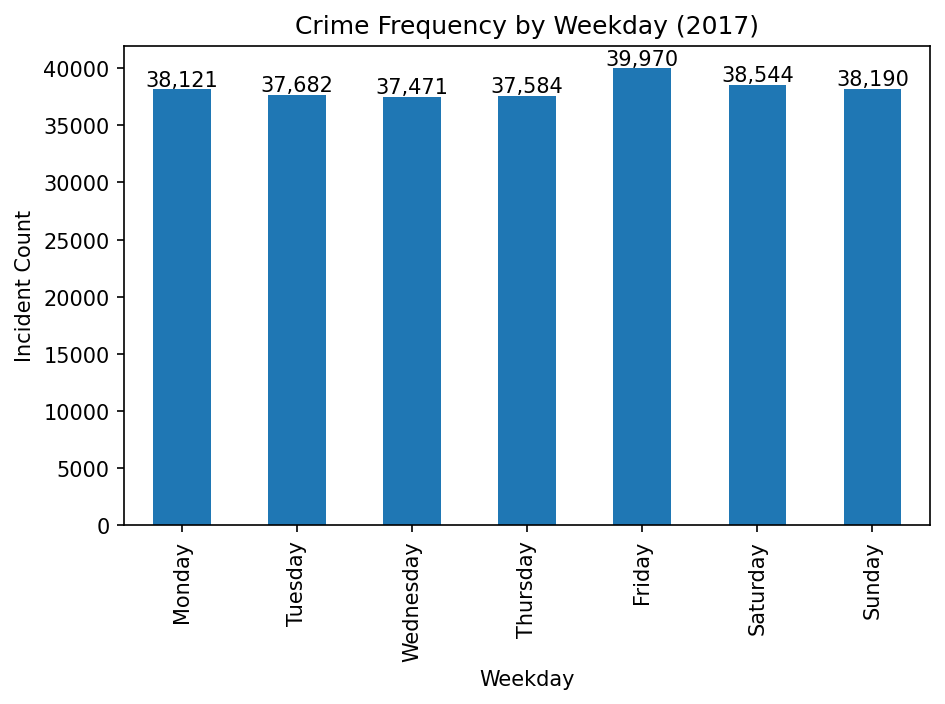

In [18]:
# ============================================
# Figure 8: Crime Frequency by Weekday (2017)
# ============================================
wd_cnt = df2017.groupBy("Weekday").count().toPandas()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wd_cnt["Weekday"] = pd.Categorical(wd_cnt["Weekday"], categories=order, ordered=True)
wd_cnt = wd_cnt.sort_values("Weekday")

ax = wd_cnt.plot(kind="bar", x="Weekday", y="count", legend=False)
ax.set_title("Crime Frequency by Weekday (2017)")
ax.set_xlabel("Weekday")
ax.set_ylabel("Incident Count")

for p in ax.patches:
  h = int(p.get_height())
  ax.text(p.get_x() + p.get_width()/2, h + 300, f"{h:,}", ha="center")

plt.tight_layout()
plt.savefig("/content/figs/figure8_by_weekday.png")
plt.show()

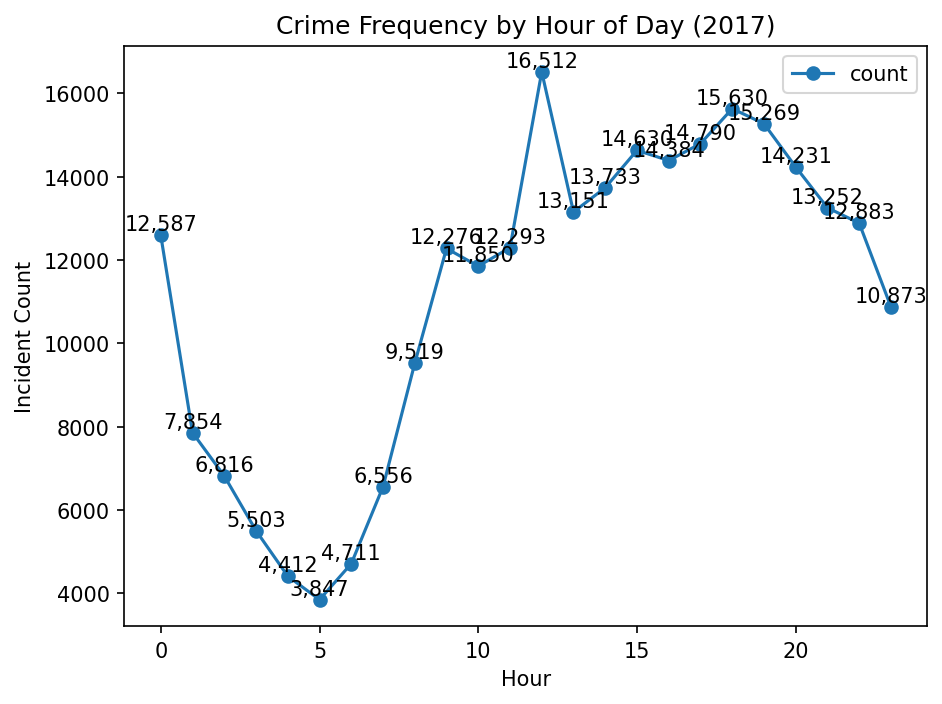

In [19]:
# ===============================================
# Figure 9: Crime Frequency by Hour of Day (2017)
# ===============================================
hour_cnt = (
    df2017.groupBy("Hour").count()
          .orderBy("Hour")
).toPandas()

ax = hour_cnt.plot(kind="line", x="Hour", y="count", marker="o")
ax.set_title("Crime Frequency by Hour of Day (2017)")
ax.set_xlabel("Hour")
ax.set_ylabel("Incident Count")

for x, y in zip(hour_cnt["Hour"], hour_cnt["count"]):
  ax.text(x, y + 120, f"{int(y):,}", ha="center")

plt.tight_layout()
plt.savefig("/content/figs/figure9_by_hour.png")
plt.show()

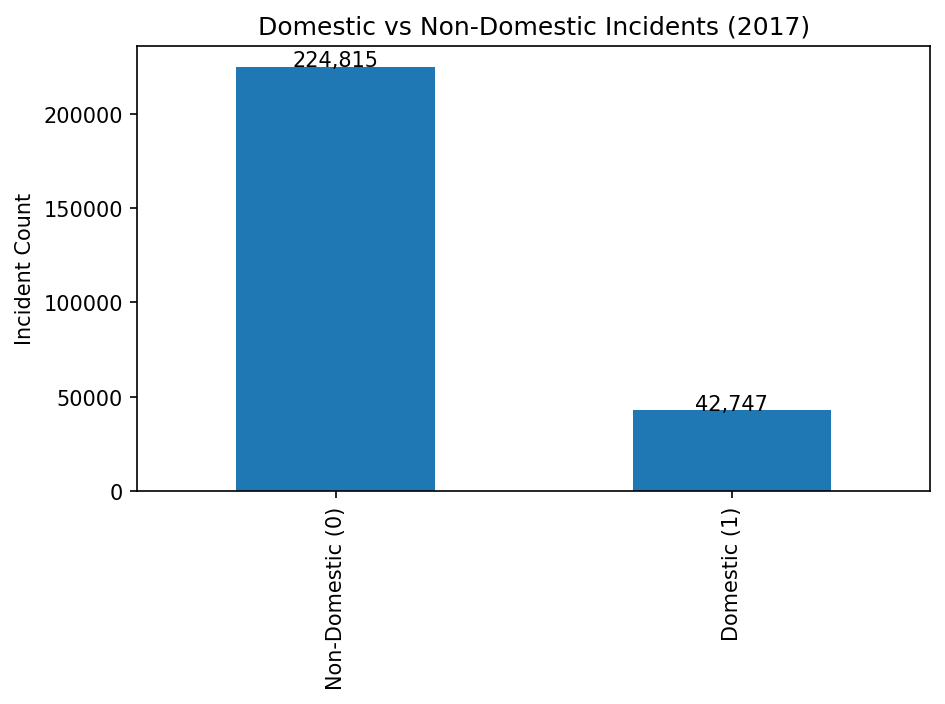

In [20]:
# ==================================================
# Figure 10: Domestic vs Non-Domestic (bar, 2017)
# ==================================================
if "Domestic" in df2017.columns:
  dom_cnt = (
      df2017.groupBy("Domestic")
            .count()
            .orderBy("Domestic")
  ).toPandas()

  # Map boolean to labels for readability
  mapping = {True: "Domestic (1)", False: "Non-Domestic (0)"}
  dom_cnt["label"] = dom_cnt["Domestic"].map(mapping)

  ax = dom_cnt.plot(kind="bar", x="label", y="count", legend=False)
  ax.set_title("Domestic vs Non-Domestic Incidents (2017)")
  ax.set_xlabel("")
  ax.set_ylabel("Incident Count")

  for p in ax.patches:
    h = int(p.get_height())
    ax.text(p.get_x() + p.get_width()/2, h + 300, f"{h:,}", ha="center")

  plt.tight_layout()
  plt.savefig("/content/figs/figure10_domestic_vs_non.png")
  plt.show()
else:
  print("Column 'Domestic' not found; skipping Figure 10.")

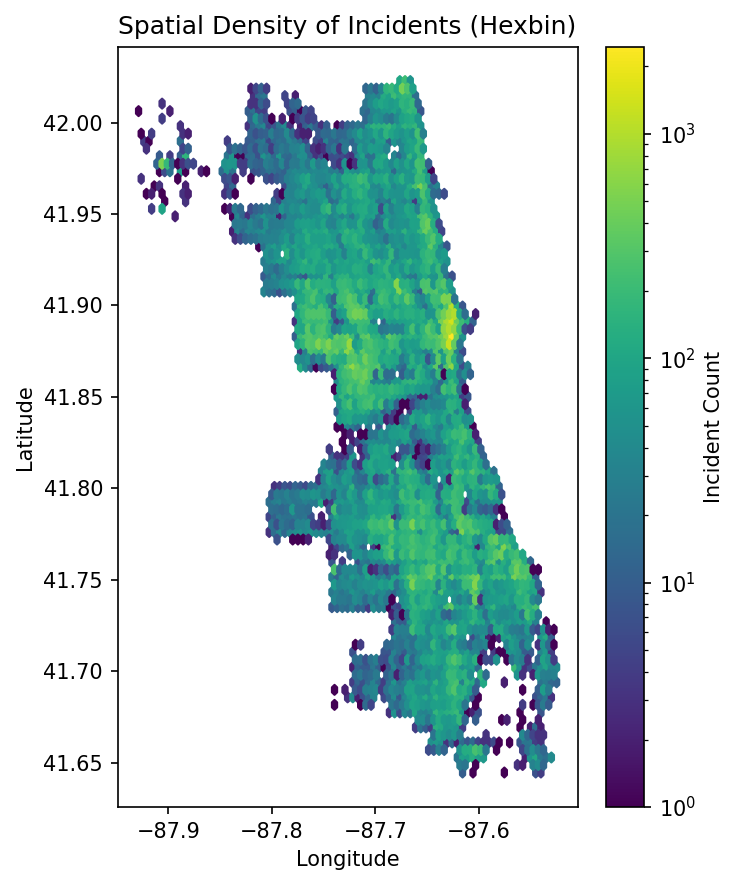

All figures saved to /content/figs/


In [21]:
# ======================================
# Figure 11: Spatial Density (Hexbin)
# ======================================
# Drop rows without coordinates; optionally clip to Chicago bounding box to remove far-out outliers.
geo_pd = (
    df2017
      .select(F.col(COL_LON).alias("lon"), F.col(COL_LAT).alias("lat"))
      .dropna(subset=["lon","lat"])
      .toPandas()
)

# Optional clipping (approximate Chicago bounding box). Uncomment if needed.
# geo_pd = geo_pd[(geo_pd["lon"].between(-87.95, -87.50)) & (geo_pd["lat"].between(41.64, 42.05))]

plt.figure(figsize=(5, 6))
hb = plt.hexbin(geo_pd["lon"], geo_pd["lat"], gridsize=80, bins="log")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Density of Incidents (Hexbin)")
cb = plt.colorbar(hb)
cb.set_label("Incident Count")
plt.tight_layout()
plt.savefig("/content/figs/figure11_hexbin.png")
plt.show()

print("All figures saved to /content/figs/")